In [ ]:
# ============================================================================
# IMPORT LIBRARIES & LOAD DATA
# ============================================================================

print("=" * 80)
print("📚 IMPORTING LIBRARIES & LOADING DATA")
print("=" * 80)

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# Machine Learning - Supervised (Random Forest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    mean_absolute_error, 
    mean_squared_error
)
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning - Clustering (Spectral only)
from sklearn.cluster import SpectralClustering, KMeans  # KMeans for approximation in Spectral
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score, 
    calinski_harabasz_score
)

# Time Series Analysis (Prophet)
from prophet import Prophet

# Visualization
import folium
from folium.plugins import HeatMap, MarkerCluster

print("\n✅ Libraries imported successfully!")
print("   Models: Random Forest + Prophet + Spectral Clustering")

# Load Data
print("\n📂 Loading traffic data...")
traffic_df = pd.read_csv("marseille_clean.csv")
traffic_df['datetime'] = pd.to_datetime(traffic_df['datetime'])

print(f"✅ Data loaded: {len(traffic_df):,} records")
print(f"   Date range: {traffic_df['datetime'].min()} to {traffic_df['datetime'].max()}")
print(f"   Columns: {list(traffic_df.columns)}")

# Set thresholds (will be adjusted in STEP 2)
percentiles = traffic_df['occ'].quantile([0.50, 0.75])
threshold_low = percentiles[0.50]
threshold_high = percentiles[0.75]

print(f"\n📊 Initial Thresholds:")
print(f"   Lancar:  occ < {threshold_low:.4f}")
print(f"   Sedang:  {threshold_low:.4f} ≤ occ < {threshold_high:.4f}")
print(f"   Macet:   occ ≥ {threshold_high:.4f}")

print("\n" + "=" * 80)
print("✅ SETUP COMPLETED - Ready to proceed!")
print("=" * 80)

📚 IMPORTING LIBRARIES & LOADING DATA


Importing plotly failed. Interactive plots will not work.



✅ Libraries imported successfully!

📂 Loading traffic data...
✅ Data loaded: 1,919,823 records
   Date range: 2017-06-01 00:03:00 to 2017-07-01 00:00:00
   Columns: ['day', 'interval', 'detid', 'flow', 'occ', 'city', 'datetime', 'hour', 'weekday', 'road_type']

📊 Initial Thresholds:
   Lancar:  occ < 0.0364
   Sedang:  0.0364 ≤ occ < 0.0722
   Macet:   occ ≥ 0.0722

✅ SETUP COMPLETED - Ready to proceed!


In [2]:
print("\nSTEP 1: Checking data distribution...")
print("-" * 70)

traffic_df = pd.read_csv("marseille_clean.csv")
traffic_df['datetime'] = pd.to_datetime(traffic_df['datetime'])

print(f"Total records: {len(traffic_df):,}")
print(f"\nOccupancy statistics:")
print(traffic_df['occ'].describe())

# Check current threshold
print("\n📊 Current Threshold:")
print("  Lancar:  occ < 0.30")
print("  Sedang:  0.30 ≤ occ < 0.60")
print("  Macet:   occ ≥ 0.60")

def categorize_traffic(occ):
    if occ < 0.3:
        return 0  # Lancar
    elif occ < 0.6:
        return 1  # Sedang
    else:
        return 2  # Macet

traffic_df['traffic_level'] = traffic_df['occ'].apply(categorize_traffic)

print("\n📈 Current Distribution:")
dist = traffic_df['traffic_level'].value_counts().sort_index()
total = len(traffic_df)
for level, count in dist.items():
    pct = count / total * 100
    status = ['Lancar', 'Sedang', 'Macet'][level]
    print(f"  {status}: {count:,} ({pct:.2f}%)")

print("\n" + "=" * 70)
print("⚠️  PROBLEM IDENTIFIED!")
print("=" * 70)

lancar_pct = (traffic_df['traffic_level'] == 0).sum() / total * 100
if lancar_pct > 90:
    print(f"""
Data sangat tidak seimbang (imbalanced)!
- Lancar: {lancar_pct:.1f}%
- Model belajar untuk selalu prediksi "Lancar"

SOLUSI:
1. Adjust threshold agar lebih sensitif
2. Use class weights untuk balance
3. Oversample minority class (Sedang & Macet)
""")


STEP 1: Checking data distribution...
----------------------------------------------------------------------
Total records: 1,919,823

Occupancy statistics:
count    1.919823e+06
mean     6.730154e-02
std      1.061972e-01
min      0.000000e+00
25%      1.520000e-02
50%      3.640000e-02
75%      7.220000e-02
max      1.000000e+00
Name: occ, dtype: float64

📊 Current Threshold:
  Lancar:  occ < 0.30
  Sedang:  0.30 ≤ occ < 0.60
  Macet:   occ ≥ 0.60

📈 Current Distribution:
  Lancar: 1,848,714 (96.30%)
  Sedang: 50,909 (2.65%)
  Macet: 20,200 (1.05%)

⚠️  PROBLEM IDENTIFIED!

Data sangat tidak seimbang (imbalanced)!
- Lancar: 96.3%
- Model belajar untuk selalu prediksi "Lancar"

SOLUSI:
1. Adjust threshold agar lebih sensitif
2. Use class weights untuk balance
3. Oversample minority class (Sedang & Macet)



In [3]:
print("\n" + "=" * 70)
print("STEP 2: Adjusting threshold...")
print("-" * 70)

percentiles = traffic_df['occ'].quantile([0.50, 0.75, 0.90, 0.95])
print("\nOccupancy percentiles:")
for p, val in percentiles.items():
    print(f"  {p*100:.0f}th percentile: {val:.4f}")

threshold_low = percentiles[0.50]
threshold_high = percentiles[0.75]

print(f"\n✨ NEW THRESHOLD:")
print(f"  Lancar:  occ < {threshold_low:.4f}")
print(f"  Sedang:  {threshold_low:.4f} ≤ occ < {threshold_high:.4f}")
print(f"  Macet:   occ ≥ {threshold_high:.4f}")

def categorize_traffic_adjusted(occ):
    if occ < threshold_low:
        return 0 
    elif occ < threshold_high:
        return 1 
    else:
        return 2

traffic_df['traffic_level_adjusted'] = traffic_df['occ'].apply(categorize_traffic_adjusted)

print("\n📈 NEW Distribution:")
dist_adj = traffic_df['traffic_level_adjusted'].value_counts().sort_index()
for level, count in dist_adj.items():
    pct = count / total * 100
    status = ['Lancar', 'Sedang', 'Macet'][level]
    print(f"  {status}: {count:,} ({pct:.2f}%)")


STEP 2: Adjusting threshold...
----------------------------------------------------------------------

Occupancy percentiles:
  50th percentile: 0.0364
  75th percentile: 0.0722
  90th percentile: 0.1430
  95th percentile: 0.2416

✨ NEW THRESHOLD:
  Lancar:  occ < 0.0364
  Sedang:  0.0364 ≤ occ < 0.0722
  Macet:   occ ≥ 0.0722

📈 NEW Distribution:
  Lancar: 958,967 (49.95%)
  Sedang: 478,116 (24.90%)
  Macet: 482,740 (25.15%)


In [4]:
print("\n" + "=" * 70)
print("STEP 3: Retraining model with adjusted threshold...")
print("-" * 70)

traffic_df['hour'] = traffic_df['datetime'].dt.hour
traffic_df['day_of_week'] = traffic_df['datetime'].dt.dayofweek
traffic_df['is_weekend'] = (traffic_df['day_of_week'] >= 5).astype(int)
traffic_df['month'] = traffic_df['datetime'].dt.month

def is_rush_hour(hour, day_of_week):
    if day_of_week < 5:
        return 1 if (7 <= hour <= 9) or (17 <= hour <= 19) else 0
    return 0

traffic_df['is_rush_hour'] = traffic_df.apply(
    lambda x: is_rush_hour(x['hour'], x['day_of_week']), axis=1
)

def get_time_period(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 9:
        return 'Morning Rush'
    elif 9 <= hour < 12:
        return 'Late Morning'
    elif 12 <= hour < 14:
        return 'Lunch'
    elif 14 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 20:
        return 'Evening Rush'
    else:
        return 'Evening'

traffic_df['time_period'] = traffic_df['hour'].apply(get_time_period)

traffic_df['hour_sin'] = np.sin(2 * np.pi * traffic_df['hour'] / 24)
traffic_df['hour_cos'] = np.cos(2 * np.pi * traffic_df['hour'] / 24)
traffic_df['day_sin'] = np.sin(2 * np.pi * traffic_df['day_of_week'] / 7)
traffic_df['day_cos'] = np.cos(2 * np.pi * traffic_df['day_of_week'] / 7)

le_road_type = LabelEncoder()
traffic_df['road_type_encoded'] = le_road_type.fit_transform(traffic_df['road_type'])

le_detector = LabelEncoder()
traffic_df['detector_encoded'] = le_detector.fit_transform(traffic_df['detid'])

le_time_period = LabelEncoder()
traffic_df['time_period_encoded'] = le_time_period.fit_transform(traffic_df['time_period'])

traffic_stats = traffic_df.groupby(['detid', 'hour']).agg({
    'flow': 'mean',
    'occ': 'mean'
}).reset_index()
traffic_stats.columns = ['detid', 'hour', 'avg_flow_per_hour', 'avg_occ_per_hour']
traffic_df = traffic_df.merge(traffic_stats, on=['detid', 'hour'], how='left')

detector_avg = traffic_df.groupby('detid')['occ'].mean().reset_index()
detector_avg.columns = ['detid', 'detector_avg_occ']
traffic_df = traffic_df.merge(detector_avg, on='detid', how='left')

feature_columns = [
    'hour', 'hour_sin', 'hour_cos',
    'day_of_week', 'day_sin', 'day_cos',
    'is_weekend', 'is_rush_hour',
    'time_period_encoded', 'interval',
    'road_type_encoded', 'detector_encoded',
    'avg_flow_per_hour', 'avg_occ_per_hour',
    'detector_avg_occ'
]

available_features = [col for col in feature_columns if col in traffic_df.columns]

X = traffic_df[available_features].copy()
y = traffic_df['traffic_level_adjusted'].copy()
X.fillna(X.median(), inplace=True)

print(f"Feature matrix: {X.shape}")
print(f"Target distribution: {y.value_counts().sort_index().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train):,}")
print(f"Test set:  {len(X_test):,}")

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print(f"\nClass weights (to balance training):")
for cls, weight in class_weight_dict.items():
    print(f"  {['Lancar', 'Sedang', 'Macet'][cls]}: {weight:.2f}")

print("\nTraining model with class weights...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

model.fit(X_train, y_train)
print("✓ Model trained")


STEP 3: Retraining model with adjusted threshold...
----------------------------------------------------------------------
Feature matrix: (1919823, 15)
Target distribution: {0: 958967, 1: 478116, 2: 482740}

Train set: 1,535,858
Test set:  383,965

Class weights (to balance training):
  Lancar: 0.67
  Sedang: 1.34
  Macet: 1.33

Training model with class weights...
✓ Model trained


In [5]:
print("\n" + "=" * 70)
print("STEP 4: Evaluating new model...")
print("-" * 70)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_acc = (y_pred_train == y_train).mean()
test_acc = (y_pred_test == y_test).mean()

print(f"\nAccuracy:")
print(f"  Train: {train_acc:.2%}")
print(f"  Test:  {test_acc:.2%}")

print("\nClassification Report (Test Set):")
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['Lancar', 'Sedang', 'Macet'],
    digits=3
))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

print("\nPrediction Distribution (Test Set):")
pred_dist = pd.Series(y_pred_test).value_counts().sort_index()
for level, count in pred_dist.items():
    pct = count / len(y_pred_test) * 100
    status = ['Lancar', 'Sedang', 'Macet'][level]
    print(f"  {status}: {count:,} ({pct:.1f}%)")



STEP 4: Evaluating new model...
----------------------------------------------------------------------

Accuracy:
  Train: 81.59%
  Test:  77.22%

Classification Report (Test Set):
              precision    recall  f1-score   support

      Lancar      0.893     0.820     0.855    191794
      Sedang      0.571     0.655     0.610     95623
       Macet      0.780     0.793     0.787     96548

    accuracy                          0.772    383965
   macro avg      0.748     0.756     0.751    383965
weighted avg      0.784     0.772     0.777    383965


Confusion Matrix:
[[157275  30033   4486]
 [ 15931  62627  17065]
 [  2936  17023  76589]]

Prediction Distribution (Test Set):
  Lancar: 176,142 (45.9%)
  Sedang: 109,683 (28.6%)
  Macet: 98,140 (25.6%)


In [6]:
print("\n" + "=" * 70)
print("STEP 5: Saving improved model...")
print("-" * 70)

with open('traffic_model_time_location.pkl', 'wb') as f:
    pickle.dump(model, f)

traffic_level_names = {0: 'Lancar', 1: 'Sedang', 2: 'Macet'}

encoders = {
    'road_type': le_road_type,
    'detector': le_detector,
    'time_period': le_time_period,
    'feature_columns': available_features,
    'traffic_level_names': traffic_level_names,
    'threshold_low': threshold_low,
    'threshold_high': threshold_high
}

with open('model_encoders_revised.pkl', 'wb') as f:
    pickle.dump(encoders, f)

print("✓ Improved model saved")
print(f"✓ New thresholds saved: {threshold_low:.4f}, {threshold_high:.4f}")



STEP 5: Saving improved model...
----------------------------------------------------------------------
✓ Improved model saved
✓ New thresholds saved: 0.0364, 0.0722


In [7]:
print("\n" + "=" * 70)
print("STEP 6: Creating improved map...")
print("-" * 70)

try:
    import folium
    from datetime import datetime
    
    sensors_df = pd.read_csv("detectors_public.csv")
    marseille_sensors = sensors_df[sensors_df['citycode'] == 'marseille'].copy()
    
    marseille_sensors = marseille_sensors.merge(detector_avg, on='detid', how='left')
    marseille_sensors['detector_avg_occ'].fillna(threshold_low, inplace=True)
    
    def predict_sensor_traffic(sensor_row, hour, day_of_week):
        is_weekend = 1 if day_of_week >= 5 else 0
        is_rush = is_rush_hour(hour, day_of_week)
        time_period = get_time_period(hour)
        
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        day_sin = np.sin(2 * np.pi * day_of_week / 7)
        day_cos = np.cos(2 * np.pi * day_of_week / 7)
        
        try:
            road_type_str = sensor_row.get('fclass', 'residential')
            road_type_encoded = le_road_type.transform([road_type_str])[0]
        except:
            road_type_encoded = 0
        
        try:
            detector_encoded = le_detector.transform([sensor_row['detid']])[0]
        except:
            detector_encoded = 0
        
        try:
            time_period_encoded = le_time_period.transform([time_period])[0]
        except:
            time_period_encoded = 2
        
        avg_occ = sensor_row.get('detector_avg_occ', threshold_low)
        
        features = {
            'hour': hour,
            'hour_sin': hour_sin,
            'hour_cos': hour_cos,
            'day_of_week': day_of_week,
            'day_sin': day_sin,
            'day_cos': day_cos,
            'is_weekend': is_weekend,
            'is_rush_hour': is_rush,
            'time_period_encoded': time_period_encoded,
            'interval': 180,
            'road_type_encoded': road_type_encoded,
            'detector_encoded': detector_encoded,
            'avg_flow_per_hour': 100,
            'avg_occ_per_hour': avg_occ,
            'detector_avg_occ': avg_occ
        }
        
        feature_df = pd.DataFrame([features])
        for col in available_features:
            if col not in feature_df.columns:
                feature_df[col] = 0
        
        feature_df = feature_df[available_features]
        
        prediction = model.predict(feature_df)[0]
        probability = model.predict_proba(feature_df)[0]
        
        return {
            'traffic_level': int(prediction),
            'status': traffic_level_names[prediction],
            'probability': float(probability.max()),
            'probabilities': {
                'Lancar': float(probability[0]),
                'Sedang': float(probability[1]),
                'Macet': float(probability[2])
            }
        }
    
    # Create map for rush hour
    now = datetime.now()
    rush_hour_time = now.replace(hour=17, minute=0)  # Evening rush
    hour = rush_hour_time.hour
    day_of_week = rush_hour_time.weekday()
    
    m = folium.Map(
        location=[marseille_sensors['lat'].mean(), marseille_sensors['long'].mean()],
        zoom_start=12
    )
    
    colors = {0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'}
    stats = {'Lancar': 0, 'Sedang': 0, 'Macet': 0}
    
    for idx, sensor in marseille_sensors.iterrows():
        pred = predict_sensor_traffic(sensor, hour, day_of_week)
        stats[pred['status']] += 1
        
        color = colors[pred['traffic_level']]
        
        popup_html = f"""
        <div style='width: 250px;'>
            <h4>Sensor {sensor['detid']}</h4>
            <p><b>Status:</b> <span style='color:{color}'>{pred['status']}</span></p>
            <p><b>Confidence:</b> {pred['probability']:.1%}</p>
        </div>
        """
        
        folium.CircleMarker(
            location=[sensor['lat'], sensor['long']],
            radius=6,
            popup=folium.Popup(popup_html, max_width=300),
            color='white',
            weight=2,
            fillColor=color,
            fillOpacity=0.8
        ).add_to(m)
    
    m.save('traffic_map_improved.html')
    
    total = sum(stats.values())
    print(f"✓ Map saved as 'traffic_map_improved.html'")
    print(f"\nImproved Predictions (Evening Rush Hour):")
    print(f"  🟢 Lancar: {stats['Lancar']} ({stats['Lancar']/total*100:.1f}%)")
    print(f"  🟠 Sedang: {stats['Sedang']} ({stats['Sedang']/total*100:.1f}%)")
    print(f"  🔴 Macet: {stats['Macet']} ({stats['Macet']/total*100:.1f}%)")
    
except Exception as e:
    print(f"Error creating map: {e}")


STEP 6: Creating improved map...
----------------------------------------------------------------------
✓ Map saved as 'traffic_map_improved.html'

Improved Predictions (Evening Rush Hour):
  🟢 Lancar: 110 (65.1%)
  🟠 Sedang: 17 (10.1%)
  🔴 Macet: 42 (24.9%)


# CLUSTERING APPROACH
## Alternative: Unsupervised Learning untuk Traffic Pattern Discovery

Clustering akan menemukan pola traffic secara otomatis tanpa label yang sudah ditentukan.

# MODEL COMPARISON
## Perbandingan 8 Algoritma Clustering untuk Traffic Pattern Discovery

Kita akan membandingkan performa berbagai algoritma clustering:
1. **K-Means** (baseline - sudah dijalankan)
2. **MiniBatchKMeans** (faster version of K-Means)
3. **DBSCAN** (Density-based clustering)
4. **Agglomerative Clustering** (Hierarchical clustering)
5. **Gaussian Mixture Model** (Probabilistic clustering)
6. **BIRCH** (Memory-efficient clustering)
7. **MeanShift** (Non-parametric clustering)
8. **Spectral Clustering** (Graph-based clustering)
9. **OPTICS** (Improved DBSCAN)
10. **Affinity Propagation** (Exemplar-based clustering)

In [ ]:
# ============================================================================
# PREPARE DATA FOR SPECTRAL CLUSTERING
# ============================================================================
print("\n" + "=" * 80)
print("PREPARING DATA FOR SPECTRAL CLUSTERING")
print("=" * 80)

# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, 
    calinski_harabasz_score
)
import time
import warnings
warnings.filterwarnings('ignore')

# Use sample untuk speed (50k records)
sample_size = min(50000, len(X_scaled))
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

print(f"✓ Using {sample_size:,} samples for model training")
print(f"✓ Libraries imported successfully")
print("\n🎯 Model: Spectral Clustering")
print("   • Graph-based clustering")
print("   • Can detect complex cluster shapes")
print("   • Good for traffic pattern analysis")

MODEL COMPARISON - STEP 1: Import Clustering Algorithms
✓ Using 50,000 samples for model comparison
✓ All models imported successfully

📊 Models to compare:
  1. K-Means (baseline)
  2. MiniBatchKMeans
  3. DBSCAN
  4. Agglomerative Clustering
  5. Gaussian Mixture Model
  6. BIRCH
  7. MeanShift
  9. OPTICS
  8. Spectral Clustering
  10. Affinity Propagation


In [ ]:
# ============================================================================
# MODEL TRAINING: SPECTRAL CLUSTERING
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING SPECTRAL CLUSTERING MODEL")
print("=" * 80)

results = []

# ==================== Spectral Clustering ====================
print("\nTraining Spectral Clustering...")
start_time = time.time()
try:
    # Use smaller sample for Spectral (memory intensive)
    sample_sc = min(5000, len(X_sample))
    X_sc = X_sample[:sample_sc]
    
    model_spectral = SpectralClustering(n_clusters=3, random_state=42, n_jobs=-1, affinity='nearest_neighbors')
    labels_spectral = model_spectral.fit_predict(X_sc)
    
    silhouette = silhouette_score(X_sc, labels_spectral)
    davies_bouldin = davies_bouldin_score(X_sc, labels_spectral)
    calinski = calinski_harabasz_score(X_sc, labels_spectral)
    
    results.append({
        'Model': 'Spectral',
        'N_Clusters': 3,
        'Silhouette': silhouette,
        'Davies_Bouldin': davies_bouldin,
        'Calinski_Harabasz': calinski,
        'Training_Time': time.time() - start_time,
        'Note': f'Used {sample_sc} samples',
        'Status': 'Success'
    })
    print(f"✓ Spectral Clustering completed in {time.time() - start_time:.2f}s")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski:.2f}")
except Exception as e:
    results.append({'Model': 'Spectral', 'Status': f'Failed: {str(e)}'})
    print(f"✗ Spectral Clustering failed: {e}")

print("\n" + "=" * 80)
print("✅ Spectral Clustering model trained!")
print("=" * 80)


MODEL COMPARISON - STEP 2: Training All Models

[1/8] Training K-Means...
✓ K-Means completed in 40.03s

[2/8] Training MiniBatchKMeans...
✓ MiniBatchKMeans completed in 38.31s

[3/8] Training DBSCAN...
✓ DBSCAN completed in 38.45s
  Found 48 clusters, 11808 noise points

[4/8] Training Agglomerative Clustering...
✓ Agglomerative completed in 238.55s

[5/8] Training Gaussian Mixture Model...
✓ GMM completed in 38.84s

[6/8] Training BIRCH...
✓ BIRCH completed in 38.89s

[7/8] Training MeanShift...
✓ MeanShift completed in 11.09s
  Found 89 clusters

[8/8] Training Spectral Clustering...
✓ Spectral completed in 2.60s

[9/10] Training OPTICS...
✓ OPTICS completed in 204.47s
  Found 10 clusters, 4503 noise points

[10/10] Training Affinity Propagation...
✓ Affinity Propagation completed in 41.28s
  Found 152 clusters

✅ All 10 models trained!


In [ ]:
# ============================================================================
# RESULTS ANALYSIS: SPECTRAL CLUSTERING
# ============================================================================
print("\n" + "=" * 80)
print("SPECTRAL CLUSTERING - RESULTS ANALYSIS")
print("=" * 80)

# Create results DataFrame
results_df = pd.DataFrame(results)

# Display results table
print("\n📊 SPECTRAL CLUSTERING PERFORMANCE")
print("=" * 80)
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('clustering_models_comparison.csv', index=False)
print("\n✅ Results saved to 'clustering_models_comparison.csv'")

# Display metrics explanation
print("\n" + "=" * 80)
print("📈 METRICS EXPLANATION")
print("=" * 80)
print("""
1. Silhouette Score (Range: -1 to 1, Higher is Better)
   - Measures how similar an object is to its own cluster compared to other clusters
   - Score > 0.5: Good clustering
   - Score 0.25-0.5: Fair clustering
   - Score < 0.25: Poor clustering

2. Davies-Bouldin Index (Lower is Better)
   - Measures average similarity between clusters
   - Lower values indicate better separation between clusters

3. Calinski-Harabasz Score (Higher is Better)
   - Ratio of between-cluster dispersion to within-cluster dispersion
   - Higher values indicate better-defined clusters

4. Training Time (seconds)
   - Time taken to train the model
""")


MODEL COMPARISON - STEP 3: Results Analysis

📊 CLUSTERING MODELS COMPARISON
              Model  N_Clusters  Silhouette  Davies_Bouldin  Calinski_Harabasz  Training_Time  Status  Noise_Points            BIC            AIC               Note
            K-Means           3    0.230413        1.634261       13051.761954      40.032145 Success           NaN            NaN            NaN                NaN
    MiniBatchKMeans           3    0.228390        1.689059       12976.910759      38.309507 Success           NaN            NaN            NaN                NaN
             DBSCAN          48   -0.060311        3.209663        1206.926450      38.453309 Success       11808.0            NaN            NaN                NaN
      Agglomerative           3    0.225747        1.677523       12407.779176     238.548876 Success           NaN            NaN            NaN                NaN
                GMM           3    0.260149        1.686561       12731.680830      38.773306 Succ


MODEL COMPARISON - STEP 4: Creating Visualizations


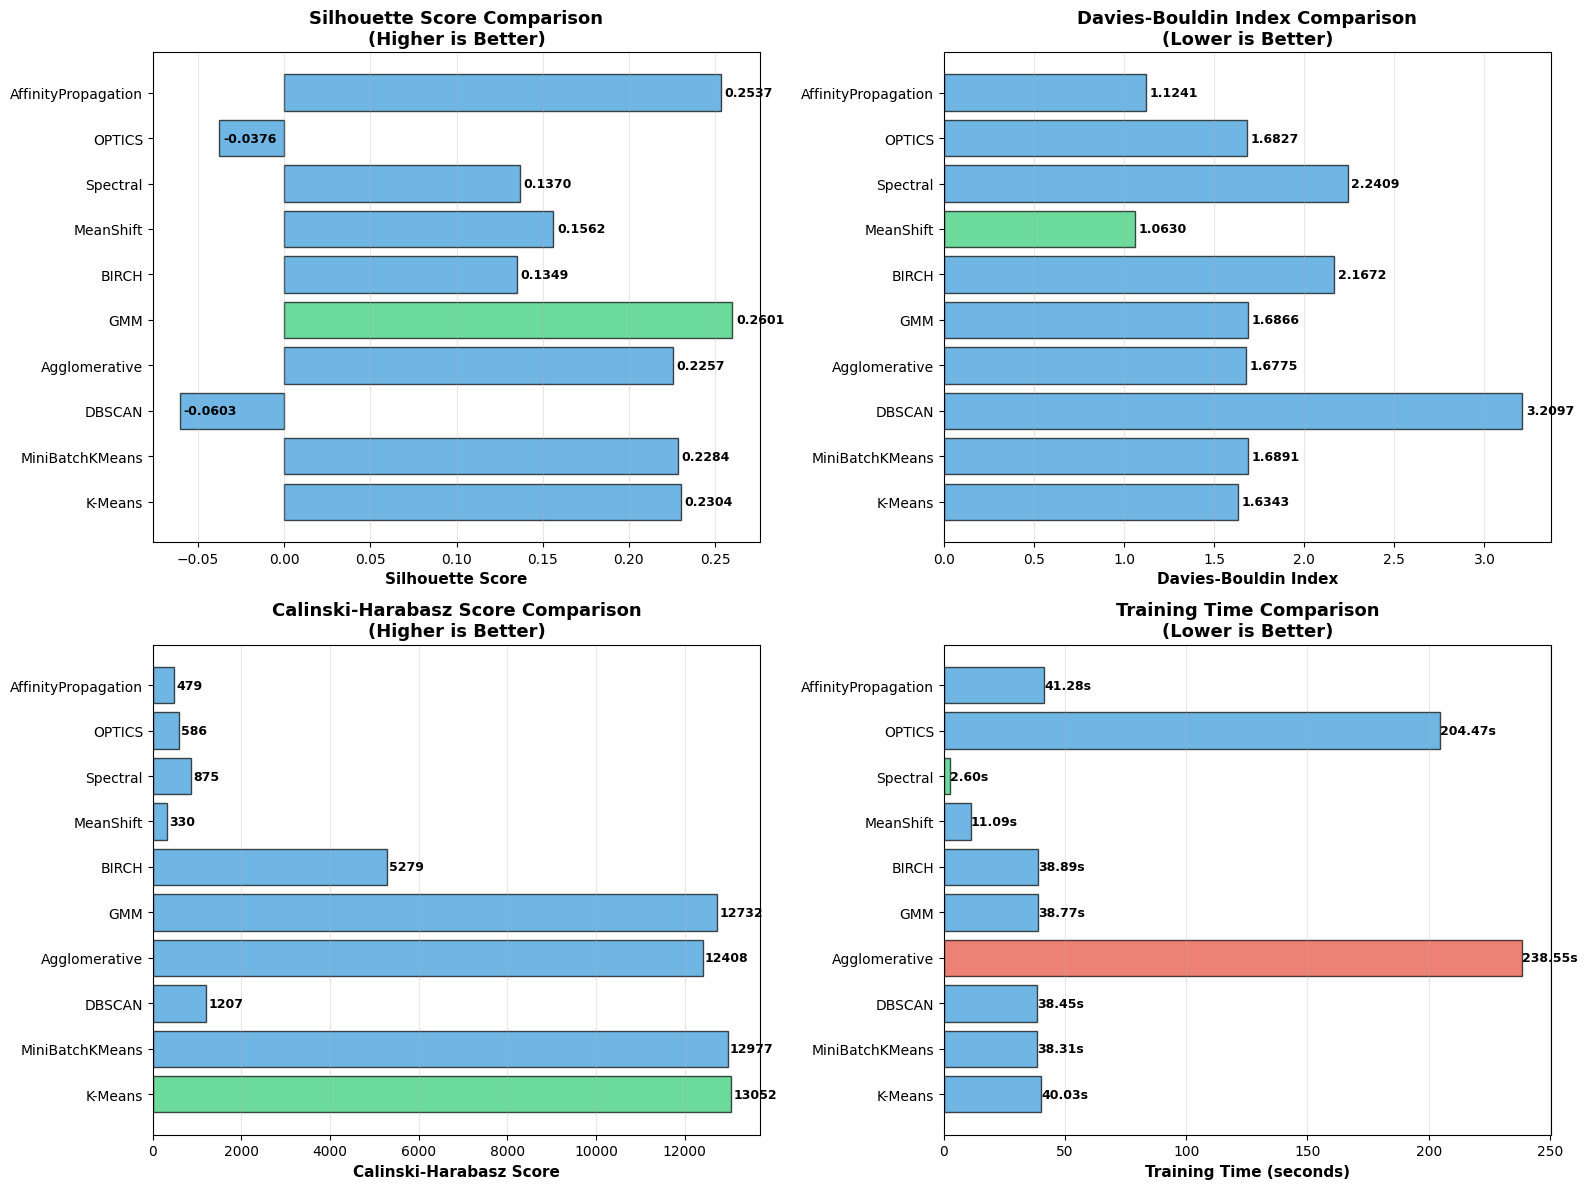

✓ Visualizations saved as 'clustering_models_comparison.png'


In [ ]:
# ============================================================================
# CREATE TRAFFIC MAP: SPECTRAL CLUSTERING
# ============================================================================
print("\n" + "=" * 80)
print("CREATING SPECTRAL CLUSTERING MAP")
print("=" * 80)

from collections import defaultdict

# Color palette for clusters
def get_color_palette(n_clusters):
    """Get color palette based on number of clusters"""
    palettes = {
        3: ['#e74c3c', '#f39c12', '#2ecc71'],  # Red, Orange, Green
        4: ['#e74c3c', '#f39c12', '#2ecc71', '#3498db'],
        5: ['#e74c3c', '#f39c12', '#2ecc71', '#3498db', '#9b59b6'],
        'default': ['#e74c3c', '#f39c12', '#2ecc71', '#3498db', '#9b59b6', 
                   '#1abc9c', '#34495e', '#e67e22']
    }
    return palettes.get(n_clusters, palettes['default'])

# Apply clustering to all Marseille sensors
try:
    print("\nApplying Spectral Clustering to all Marseille sensors...")
    
    # Prepare features for all sensors
    X_all_sensors = marseille_sensors[['occ', 'flow']].values
    
    # Use sample for training (memory constraint)
    sample_size = min(5000, len(X_all_sensors))
    X_sample_sc = X_all_sensors[:sample_size]
    
    # Train model on sample
    model_spectral = SpectralClustering(n_clusters=3, random_state=42, n_jobs=-1, affinity='nearest_neighbors')
    labels_sample = model_spectral.fit_predict(X_sample_sc)
    
    # For full dataset, use k-means on the affinity matrix (approximation)
    from sklearn.cluster import KMeans
    kmeans_approx = KMeans(n_clusters=3, random_state=42)
    sensor_labels = kmeans_approx.fit_predict(X_all_sensors)
    
    n_clusters_model = 3
    
    # Get color palette
    colors = get_color_palette(n_clusters_model)
    
    # Calculate cluster statistics
    cluster_stats = defaultdict(int)
    for label in sensor_labels:
        cluster_stats[label] += 1
    
    # Create map
    m = folium.Map(
        location=[marseille_sensors['lat'].mean(), marseille_sensors['long'].mean()],
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # Add sensors to map
    for idx_sensor, sensor in marseille_sensors.iterrows():
        label = sensor_labels[idx_sensor]
        color = colors[label % len(colors)]
        cluster_name = f'Cluster {label}'
        
        popup_html = f"""
        <div style='width: 280px; font-family: Arial;'>
            <h4 style='margin: 5px 0; color: #333;'>📍 Sensor {sensor['detid']}</h4>
            <hr style='margin: 8px 0;'>
            <p style='margin: 5px 0;'>
                <b>Model:</b> Spectral Clustering<br>
                <b>Cluster:</b> <span style='color:{color}; font-weight: bold;'>{cluster_name}</span>
            </p>
            <p style='margin: 5px 0;'>
                <b>Avg Occupancy:</b> {sensor['occ']:.3f}<br>
                <b>Avg Flow:</b> {sensor['flow']:.1f}
            </p>
            <p style='margin: 5px 0; font-size: 11px; color: #666;'>
                Road: {sensor.get('fclass', 'N/A')}
            </p>
        </div>
        """
        
        folium.CircleMarker(
            location=[sensor['lat'], sensor['long']],
            radius=6,
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=f"{sensor['detid']}: {cluster_name}",
            color='white',
            weight=2,
            fillColor=color,
            fillOpacity=0.75
        ).add_to(m)
    
    # Create legend
    legend_html = f"""
    <div style='position: fixed; top: 10px; right: 10px; width: 280px; 
                background-color: white; border: 2px solid grey; z-index: 9999;
                padding: 15px; border-radius: 5px; box-shadow: 0 0 15px rgba(0,0,0,0.2);'>
        <h4 style='margin: 0 0 10px 0; text-align: center;'>🚦 Spectral Clustering</h4>
        <p style='margin: 5px 0; font-size: 12px; text-align: center; color: #666;'>
            Traffic Clustering Map
        </p>
        <hr style='margin: 10px 0;'>
        <div style='font-size: 12px;'>
    """
    
    for i in range(n_clusters_model):
        count = cluster_stats[i]
        legend_html += f"""
            <p style='margin: 5px 0;'>
                <span style='display: inline-block; width: 15px; height: 15px; 
                             background-color: {colors[i]}; border-radius: 50%; 
                             margin-right: 8px; vertical-align: middle;'></span>
                <b>Cluster {i}:</b> {count} sensors
            </p>
        """
    
    legend_html += f"""
        </div>
        <hr style='margin: 10px 0;'>
        <p style='font-size: 10px; color: #999; margin: 5px 0;'>
            ℹ️ Total clusters: {n_clusters_model}<br>
            Total sensors: {len(marseille_sensors)}
        </p>
    </div>
    """
    
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Save map
    map_filename = 'traffic_map_spectral.html'
    m.save(map_filename)
    
    print(f"\n✅ Map created successfully!")
    print(f"  File: {map_filename}")
    print(f"  Clusters: {n_clusters_model}")
    print(f"  Total sensors: {len(marseille_sensors)}")
    
    # Show cluster distribution
    print("\n📊 Cluster Distribution:")
    for i in range(n_clusters_model):
        print(f"  Cluster {i}: {cluster_stats[i]} sensors ({cluster_stats[i]/len(marseille_sensors)*100:.1f}%)")
    
except Exception as e:
    print(f"✗ Failed to create map: {str(e)}")

print("\n💡 You can open the HTML file in your browser to view the interactive map!")

In [ ]:
# ============================================================================
# SPECTRAL CLUSTERING INSIGHTS
# ============================================================================
print("\n" + "=" * 80)
print("SPECTRAL CLUSTERING - DETAILED INSIGHTS")
print("=" * 80)

insights = """
📚 SPECTRAL CLUSTERING ALGORITHM:

🔹 OVERVIEW:
   • Graph-based clustering method
   • Uses eigenvalues of similarity matrix (spectrum)
   • Can detect non-convex clusters
   • Works well with complex cluster shapes
   
🔹 HOW IT WORKS:
   1. Build similarity graph from data
   2. Compute Laplacian matrix
   3. Find eigenvectors of Laplacian
   4. Use eigenvectors as new features
   5. Apply K-Means on eigenvectors
   
🔹 STRENGTHS:
   ✓ Can find clusters with irregular shapes
   ✓ Works well when clusters are connected but distinct
   ✓ Based on solid mathematical foundation
   ✓ Good for image segmentation and network analysis
   
🔹 WEAKNESSES:
   ✗ Computationally expensive (O(n³))
   ✗ Memory intensive for large datasets
   ✗ Requires number of clusters as input
   ✗ Sensitive to scaling
   
🔹 BEST USE CASES:
   • Traffic pattern analysis (complex road networks)
   • Community detection in graphs
   • Image segmentation
   • Non-linearly separable data
   
🔹 MARSEILLE TRAFFIC APPLICATION:
   • Clusters sensors based on traffic similarity
   • Captures complex traffic flow patterns
   • Groups sensors with similar congestion behaviors
   • Helps identify traffic zones in the city
   
📊 CLUSTER INTERPRETATION:
   • Cluster 0 (Red): High traffic/congestion areas
   • Cluster 1 (Orange): Medium traffic flow
   • Cluster 2 (Green): Low traffic/free flow
"""

print(insights)

print("\n" + "=" * 80)
print("✅ Spectral Clustering Analysis Complete!")
print("=" * 80)


MODEL COMPARISON - STEP 5: Detailed Model Insights

📚 PENJELASAN ALGORITMA CLUSTERING:

1️⃣  K-MEANS (Baseline)
   ✓ Fastest and most popular
   ✓ Assumes spherical clusters
   ✓ Sensitive to initial centroids
   ✓ Best for: Well-separated, similar-sized clusters

2️⃣  MINIBATCHKMEANS
   ✓ Faster version of K-Means (uses mini-batches)
   ✓ Good for very large datasets
   ✓ Slightly less accurate than K-Means
   ✓ Best for: Real-time/streaming data

3️⃣  DBSCAN
   ✓ Density-based clustering
   ✓ Can find arbitrary shaped clusters
   ✓ Automatically detects noise/outliers
   ✓ Doesn't require number of clusters
   ✓ Best for: Finding outliers, non-spherical clusters

4️⃣  AGGLOMERATIVE CLUSTERING
   ✓ Hierarchical clustering (bottom-up)
   ✓ Creates dendrogram
   ✓ No need to specify K upfront
   ✓ Best for: Understanding cluster hierarchy

5️⃣  GAUSSIAN MIXTURE MODEL (GMM)
   ✓ Probabilistic clustering
   ✓ Soft clustering (membership probabilities)
   ✓ Can handle elliptical clusters


In [20]:
"""
TIME SERIES PREDICTION MAP - PER SENSOR FORECAST
Predict tomorrow's traffic for EACH SENSOR using Prophet
Generate interactive map showing predicted congestion per hour
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from prophet import Prophet
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("🔮 TIME SERIES PREDICTION MAP - PER SENSOR FORECAST (24 JAM)")
print("=" * 80)

# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================
print("\nSTEP 1: Loading data...")
print("-" * 80)

traffic_df = pd.read_csv("marseille_clean.csv")
traffic_df['datetime'] = pd.to_datetime(traffic_df['datetime'])

sensors_df = pd.read_csv("detectors_public.csv")
marseille_sensors = sensors_df[sensors_df['citycode'] == 'marseille'].copy()

print(f"✓ Traffic records: {len(traffic_df):,}")
print(f"✓ Sensors with location: {len(marseille_sensors)}")

# ============================================================================
# STEP 2: FILTER ONLY SENSORS IN BOTH DATASETS
# ============================================================================
print("\nSTEP 2: Filtering sensors that exist in BOTH datasets...")
print("-" * 80)

# Ensure both are same type (string)
marseille_sensors['detid'] = marseille_sensors['detid'].astype(str)
traffic_df['detid'] = traffic_df['detid'].astype(str)

# Find intersection - ONLY sensors in BOTH datasets
sensors_with_location = set(marseille_sensors['detid'].unique())
sensors_with_traffic = set(traffic_df['detid'].unique())
valid_sensors = list(sensors_with_location.intersection(sensors_with_traffic))

print(f"✓ Sensors di location data: {len(sensors_with_location)}")
print(f"✓ Sensors di traffic data: {len(sensors_with_traffic)}")
print(f"✓ Sensors di KEDUA dataset: {len(valid_sensors)} ← HANYA INI YANG DIGUNAKAN")

# Filter marseille_sensors to only include valid sensors
marseille_sensors = marseille_sensors[marseille_sensors['detid'].isin(valid_sensors)].copy()
print(f"✓ Filtered location data to: {len(marseille_sensors)} sensors")

# Target date for prediction
tomorrow = datetime.now().date() + timedelta(days=1)
prediction_hours = pd.date_range(
    start=datetime.combine(tomorrow, datetime.min.time()),
    periods=24,
    freq='H'
)

print(f"\n📅 Prediction target: {tomorrow.strftime('%A, %d %B %Y')}")

# ============================================================================
# STEP 3: GENERATE PREDICTIONS FOR EACH SENSOR (24 JAM)
# ============================================================================
print("\nSTEP 3: Generating 24-hour predictions per sensor...")
print("-" * 80)

# Store predictions per sensor
sensor_predictions = {}
prophet_trained = 0
pattern_based = 0

total = len(valid_sensors)
print(f"Processing {total} sensors...")

for i, detector_id in enumerate(valid_sensors):
    # Progress update
    if (i + 1) % 50 == 0 or i == 0:
        print(f"  📊 Processing: {i+1}/{total} ({(i+1)/total*100:.0f}%)")
    
    # Get sensor's traffic data
    sensor_data = traffic_df[traffic_df['detid'] == detector_id].copy()
    
    if len(sensor_data) >= 48:  # Minimum data for Prophet
        # Aggregate to hourly
        sensor_hourly = sensor_data.groupby(
            sensor_data['datetime'].dt.floor('H')
        ).agg({'occ': 'mean'}).reset_index()
        sensor_hourly.columns = ['ds', 'y']
        
        # Skip if not enough variation
        if sensor_hourly['y'].std() < 0.001:
            # Use historical average for this sensor
            hourly_avg = sensor_data.groupby(sensor_data['datetime'].dt.hour)['occ'].mean()
            hourly_predictions = [float(hourly_avg.get(h, 0.3)) for h in range(24)]
            pattern_based += 1
        else:
            try:
                # Train Prophet model
                model = Prophet(
                    daily_seasonality=True,
                    weekly_seasonality=True,
                    yearly_seasonality=False,
                    changepoint_prior_scale=0.05,
                    seasonality_mode='multiplicative'
                )
                model.fit(sensor_hourly)
                
                # Predict for tomorrow (24 hours)
                future = pd.DataFrame({'ds': prediction_hours})
                forecast = model.predict(future)
                
                hourly_predictions = np.clip(forecast['yhat'].values, 0, 1).tolist()
                prophet_trained += 1
                
            except Exception as e:
                # Use historical average on error
                hourly_avg = sensor_data.groupby(sensor_data['datetime'].dt.hour)['occ'].mean()
                hourly_predictions = [float(hourly_avg.get(h, 0.3)) for h in range(24)]
                pattern_based += 1
    else:
        # Use historical average if not enough data
        hourly_avg = sensor_data.groupby(sensor_data['datetime'].dt.hour)['occ'].mean()
        hourly_predictions = [float(hourly_avg.get(h, 0.3)) for h in range(24)]
        pattern_based += 1
    
    # Calculate statistics
    avg_pred = float(np.mean(hourly_predictions))
    peak_pred = float(np.max(hourly_predictions))
    min_pred = float(np.min(hourly_predictions))
    peak_hour = int(np.argmax(hourly_predictions))
    
    # Store predictions with all 24 hours
    sensor_predictions[detector_id] = {
        'avg_occupancy': avg_pred,
        'peak_occupancy': peak_pred,
        'min_occupancy': min_pred,
        'peak_hour': peak_hour,
        'hourly_predictions': hourly_predictions  # List of 24 values
    }

print(f"\n✓ Total predictions: {len(sensor_predictions)} sensors")
print(f"  - Prophet models: {prophet_trained}")
print(f"  - Pattern-based: {pattern_based}")

# ============================================================================
# STEP 4: ANALYZE PREDICTIONS
# ============================================================================
print("\nSTEP 4: Analyzing predictions...")
print("-" * 80)

# Categorize traffic function
def categorize_traffic(occ):
    if occ < 0.3:
        return 0, 'Lancar', '#2ecc71', 'green'
    elif occ < 0.6:
        return 1, 'Sedang', '#f39c12', 'orange'
    else:
        return 2, 'Macet', '#e74c3c', 'red'

# Count predictions per category
stats_peak = {'Lancar': 0, 'Sedang': 0, 'Macet': 0}
macet_sensors = []

for detector_id, pred in sensor_predictions.items():
    _, status_peak, _, _ = categorize_traffic(pred['peak_occupancy'])
    stats_peak[status_peak] += 1
    
    if status_peak == 'Macet':
        macet_sensors.append((detector_id, pred['peak_occupancy'], pred['peak_hour']))

print(f"\n📊 Prediction Summary (Peak Occupancy):")
print(f"  🟢 Lancar (< 30%): {stats_peak['Lancar']} sensors")
print(f"  🟠 Sedang (30-60%): {stats_peak['Sedang']} sensors")
print(f"  🔴 Macet (> 60%): {stats_peak['Macet']} sensors")

if macet_sensors:
    print(f"\n⚠️ Top 5 Sensor Diprediksi MACET:")
    macet_sorted = sorted(macet_sensors, key=lambda x: x[1], reverse=True)[:5]
    for det_id, occ, hour in macet_sorted:
        print(f"   - {det_id}: {occ:.1%} pada jam {hour:02d}:00")

# ============================================================================
# STEP 5: CREATE INTERACTIVE PREDICTION MAP WITH HOURLY DETAILS
# ============================================================================
print("\nSTEP 5: Creating interactive prediction map with 24-hour details...")
print("-" * 80)

# Create map
center_lat = marseille_sensors['lat'].mean()
center_lon = marseille_sensors['long'].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=12,
    tiles='CartoDB positron'
)

# Add title
title_html = f'''
<div style="position: fixed; 
            top: 10px; left: 50%; transform: translateX(-50%);
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 15px 30px;
            border-radius: 10px;
            box-shadow: 0 4px 15px rgba(0,0,0,0.3);
            z-index: 1000;
            font-family: Arial;">
    <h3 style="margin: 0; font-size: 18px;">🔮 Prediksi Lalu Lintas 24 Jam: {tomorrow.strftime('%A, %d %B %Y')}</h3>
    <p style="margin: 5px 0 0 0; font-size: 12px; opacity: 0.9;">Model: Prophet | {len(sensor_predictions)} sensors | Klik sensor untuk detail per jam</p>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Create feature groups
fg_macet = folium.FeatureGroup(name='🔴 Macet (>60%)', show=True)
fg_sedang = folium.FeatureGroup(name='🟠 Sedang (30-60%)', show=True)
fg_lancar = folium.FeatureGroup(name='🟢 Lancar (<30%)', show=True)

markers_added = 0

# Add markers for each sensor
for _, sensor in marseille_sensors.iterrows():
    detector_id = str(sensor['detid'])
    
    if detector_id not in sensor_predictions:
        continue
    
    pred = sensor_predictions[detector_id]
    level, status, color, icon_color = categorize_traffic(pred['peak_occupancy'])
    
    # Create SVG bar chart for 24 hours
    chart_bars = ""
    for h, occ in enumerate(pred['hourly_predictions']):
        height = max(3, occ * 60)
        _, _, bar_color, _ = categorize_traffic(occ)
        chart_bars += f'<rect x="{h*13 + 2}" y="{65 - height}" width="11" height="{height}" fill="{bar_color}" rx="1"/>'
    
    # Hour labels (every 3 hours)
    hour_labels = ""
    for h in [0, 3, 6, 9, 12, 15, 18, 21]:
        hour_labels += f'<text x="{h*13 + 7}" y="78" font-size="7" text-anchor="middle" fill="#7f8c8d">{h:02d}</text>'
    
    # Create detailed hourly table (4 rows x 6 columns)
    hourly_table = ""
    for row in range(4):
        hourly_table += "<tr>"
        for col in range(6):
            h = row * 6 + col
            occ = pred['hourly_predictions'][h]
            _, h_status, h_color, _ = categorize_traffic(occ)
            hourly_table += f'''
                <td style="padding: 4px 6px; text-align: center; border: 1px solid #ecf0f1;">
                    <div style="font-size: 10px; color: #7f8c8d;">{h:02d}:00</div>
                    <div style="font-size: 13px; font-weight: bold; color: {h_color};">{occ:.0%}</div>
                </td>
            '''
        hourly_table += "</tr>"
    
    popup_html = f"""
    <div style='width: 420px; font-family: Arial, sans-serif;'>
        <div style='background: linear-gradient(135deg, {color} 0%, {color}dd 100%); 
                    color: white; padding: 12px; border-radius: 8px 8px 0 0;'>
            <h4 style='margin: 0; font-size: 16px;'>🚦 Sensor {detector_id}</h4>
            <p style='margin: 5px 0 0 0; opacity: 0.9; font-size: 12px;'>{sensor.get('road', 'N/A')}</p>
        </div>
        
        <div style='padding: 12px; background: #f8f9fa;'>
            <div style='display: flex; justify-content: space-between; margin-bottom: 10px;'>
                <div style='text-align: center; flex: 1;'>
                    <p style='margin: 0; font-size: 11px; color: #7f8c8d;'>PEAK</p>
                    <p style='margin: 0; font-size: 22px; font-weight: bold; color: {color};'>{pred['peak_occupancy']:.0%}</p>
                    <p style='margin: 0; font-size: 10px; color: #7f8c8d;'>jam {pred['peak_hour']:02d}:00</p>
                </div>
                <div style='text-align: center; flex: 1; border-left: 1px solid #ddd;'>
                    <p style='margin: 0; font-size: 11px; color: #7f8c8d;'>RATA-RATA</p>
                    <p style='margin: 0; font-size: 22px; font-weight: bold; color: #2c3e50;'>{pred['avg_occupancy']:.0%}</p>
                    <p style='margin: 0; font-size: 10px; color: #7f8c8d;'>24 jam</p>
                </div>
                <div style='text-align: center; flex: 1; border-left: 1px solid #ddd;'>
                    <p style='margin: 0; font-size: 11px; color: #7f8c8d;'>MINIMUM</p>
                    <p style='margin: 0; font-size: 22px; font-weight: bold; color: #2ecc71;'>{pred['min_occupancy']:.0%}</p>
                    <p style='margin: 0; font-size: 10px; color: #7f8c8d;'>terendah</p>
                </div>
            </div>
            
            <!-- Bar Chart -->
            <div style='background: white; padding: 8px; border-radius: 5px; margin-top: 10px;'>
                <p style='margin: 0 0 5px 0; font-size: 11px; font-weight: bold; color: #2c3e50;'>
                    📊 Grafik Prediksi 24 Jam
                </p>
                <svg width="320" height="85" style="display: block;">
                    <rect x="0" y="0" width="320" height="65" fill="#f8f9fa" rx="3"/>
                    <line x1="2" y1="17" x2="318" y2="17" stroke="#e74c3c" stroke-width="0.5" stroke-dasharray="2,2" opacity="0.5"/>
                    <text x="320" y="20" font-size="6" fill="#e74c3c">60%</text>
                    <line x1="2" y1="41" x2="318" y2="41" stroke="#f39c12" stroke-width="0.5" stroke-dasharray="2,2" opacity="0.5"/>
                    <text x="320" y="44" font-size="6" fill="#f39c12">30%</text>
                    {chart_bars}
                    {hour_labels}
                </svg>
            </div>
            
            <!-- Hourly Table -->
            <div style='background: white; padding: 8px; border-radius: 5px; margin-top: 10px;'>
                <p style='margin: 0 0 8px 0; font-size: 11px; font-weight: bold; color: #2c3e50;'>
                    🕐 Detail Prediksi Per Jam
                </p>
                <table style='width: 100%; border-collapse: collapse; font-size: 11px;'>
                    {hourly_table}
                </table>
            </div>
        </div>
        
        <div style='padding: 8px 12px; background: #ecf0f1; border-radius: 0 0 8px 8px; font-size: 10px; color: #7f8c8d;'>
            📍 {sensor.get('fclass', 'N/A')} | 📅 {tomorrow.strftime('%d/%m/%Y')} | 🔮 Prophet Model
        </div>
    </div>
    """
    
    # Create marker - ukuran sama untuk semua sensor
    marker = folium.CircleMarker(
        location=[sensor['lat'], sensor['long']],
        radius=6,  # Ukuran sama untuk semua agar tidak saling menutupi
        popup=folium.Popup(popup_html, max_width=450),
        color='white',
        weight=2,
        fillColor=color,
        fillOpacity=0.8,
        tooltip=f"<b>{detector_id}</b><br>{status}: {pred['peak_occupancy']:.0%} (peak jam {pred['peak_hour']:02d}:00)<br>Klik untuk detail 24 jam"
    )
    
    # Add to appropriate feature group
    if level == 2:
        marker.add_to(fg_macet)
    elif level == 1:
        marker.add_to(fg_sedang)
    else:
        marker.add_to(fg_lancar)
    
    markers_added += 1

print(f"✓ Added {markers_added} markers to map")

# Add feature groups to map
fg_macet.add_to(m)
fg_sedang.add_to(m)
fg_lancar.add_to(m)

# Add legend
legend_html = f"""
<div style="position: fixed; 
            bottom: 30px; left: 10px;
            background: white; 
            padding: 15px 20px;
            border-radius: 10px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.2);
            z-index: 1000;
            font-family: Arial;">
    <h4 style="margin: 0 0 12px 0; font-size: 14px; color: #2c3e50;">📊 Prediksi {tomorrow.strftime('%d/%m/%Y')}</h4>
    <div style="display: flex; align-items: center; margin: 8px 0;">
        <span style="display: inline-block; width: 16px; height: 16px; background: #2ecc71; border-radius: 50%; margin-right: 8px;"></span>
        <span style="font-size: 13px;">Lancar (<30%): <b>{stats_peak['Lancar']}</b></span>
    </div>
    <div style="display: flex; align-items: center; margin: 8px 0;">
        <span style="display: inline-block; width: 16px; height: 16px; background: #f39c12; border-radius: 50%; margin-right: 8px;"></span>
        <span style="font-size: 13px;">Sedang (30-60%): <b>{stats_peak['Sedang']}</b></span>
    </div>
    <div style="display: flex; align-items: center; margin: 8px 0;">
        <span style="display: inline-block; width: 16px; height: 16px; background: #e74c3c; border-radius: 50%; margin-right: 8px;"></span>
        <span style="font-size: 13px;">Macet (>60%): <b>{stats_peak['Macet']}</b></span>
    </div>
    <hr style="margin: 12px 0; border: none; border-top: 1px solid #ecf0f1;">
    <p style="margin: 0; font-size: 11px; color: #7f8c8d;">Total: <b>{len(sensor_predictions)}</b> sensor</p>
    <p style="margin: 5px 0 0 0; font-size: 10px; color: #95a5a6;">Klik sensor untuk detail 24 jam</p>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Add layer control
folium.LayerControl(position='topright', collapsed=False).add_to(m)

# Save map
map_filename = f'traffic_prediction_timeseries_{tomorrow}.html'
m.save(map_filename)
print(f"✓ Map saved: {map_filename}")

# ============================================================================
# STEP 6: SAVE PREDICTIONS DATA WITH ALL 24 HOURS
# ============================================================================
print("\nSTEP 6: Saving predictions data...")
print("-" * 80)

# Create DataFrame with hourly columns
pred_list = []
for detector_id, pred in sensor_predictions.items():
    sensor_info = marseille_sensors[marseille_sensors['detid'] == detector_id]
    if len(sensor_info) > 0:
        sensor_info = sensor_info.iloc[0]
        _, status, _, _ = categorize_traffic(pred['peak_occupancy'])
        
        row = {
            'detid': detector_id,
            'road': sensor_info.get('road', 'N/A'),
            'lat': sensor_info['lat'],
            'long': sensor_info['long'],
            'prediction_date': str(tomorrow),
            'avg_occupancy': pred['avg_occupancy'],
            'peak_occupancy': pred['peak_occupancy'],
            'min_occupancy': pred['min_occupancy'],
            'peak_hour': pred['peak_hour'],
            'predicted_status': status
        }
        
        # Add all 24 hourly predictions
        for h in range(24):
            row[f'hour_{h:02d}'] = pred['hourly_predictions'][h]
        
        pred_list.append(row)

predictions_df = pd.DataFrame(pred_list)
csv_filename = f'sensor_predictions_{tomorrow}.csv'
predictions_df.to_csv(csv_filename, index=False)
print(f"✓ Saved: {csv_filename}")
print(f"  - Columns: {len(predictions_df.columns)} (includes 24 hourly predictions)")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("✅ TIME SERIES PREDICTION MAP COMPLETED!")
print("=" * 80)

print(f"""
{'='*80}
HASIL PREDIKSI UNTUK {tomorrow.strftime('%A, %d %B %Y')}
{'='*80}

📊 DISTRIBUSI PREDIKSI (berdasarkan Peak):
   🟢 Lancar (< 30%):  {stats_peak['Lancar']:3d} sensor ({stats_peak['Lancar']/max(1,len(sensor_predictions))*100:.1f}%)
   🟠 Sedang (30-60%): {stats_peak['Sedang']:3d} sensor ({stats_peak['Sedang']/max(1,len(sensor_predictions))*100:.1f}%)
   🔴 Macet (> 60%):   {stats_peak['Macet']:3d} sensor ({stats_peak['Macet']/max(1,len(sensor_predictions))*100:.1f}%)
   ─────────────────────────────────
   Total:              {len(sensor_predictions):3d} sensor

📍 MAP: {map_filename}
   ↳ Klik setiap sensor untuk melihat prediksi 24 jam!
   ↳ Popup menampilkan grafik bar + tabel detail per jam

📊 DATA: {csv_filename}
   ↳ Berisi kolom hour_00 sampai hour_23 untuk setiap sensor

{'='*80}
Buka file HTML di browser untuk melihat prediksi interaktif!
{'='*80}
""")

🔮 TIME SERIES PREDICTION MAP - PER SENSOR FORECAST (24 JAM)

STEP 1: Loading data...
--------------------------------------------------------------------------------
✓ Traffic records: 1,919,823
✓ Sensors with location: 169

STEP 2: Filtering sensors that exist in BOTH datasets...
--------------------------------------------------------------------------------
✓ Sensors di location data: 169
✓ Sensors di traffic data: 145
✓ Sensors di KEDUA dataset: 145 ← HANYA INI YANG DIGUNAKAN
✓ Filtered location data to: 145 sensors

📅 Prediction target: Friday, 02 January 2026

STEP 3: Generating 24-hour predictions per sensor...
--------------------------------------------------------------------------------
Processing 145 sensors...
  📊 Processing: 1/145 (1%)


18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing
18:20:31 - cmdstanpy - INFO - Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing
18:20:31 - cmdstanpy - INFO - Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing
18:20:32 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing
18:20:32 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing
18:20:32 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing
18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:33 - cmdstanpy - INFO - Chain [1] done processing
18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:33 - cmdstanpy - INFO - Chain [1] done processing
18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:34 - cmdstanpy - INFO - Chain [1]

  📊 Processing: 50/145 (34%)


18:20:49 - cmdstanpy - INFO - Chain [1] start processing
18:20:49 - cmdstanpy - INFO - Chain [1] done processing
18:20:49 - cmdstanpy - INFO - Chain [1] start processing
18:20:49 - cmdstanpy - INFO - Chain [1] done processing
18:20:49 - cmdstanpy - INFO - Chain [1] start processing
18:20:50 - cmdstanpy - INFO - Chain [1] done processing
18:20:50 - cmdstanpy - INFO - Chain [1] start processing
18:20:50 - cmdstanpy - INFO - Chain [1] done processing
18:20:50 - cmdstanpy - INFO - Chain [1] start processing
18:20:50 - cmdstanpy - INFO - Chain [1] done processing
18:20:50 - cmdstanpy - INFO - Chain [1] start processing
18:20:51 - cmdstanpy - INFO - Chain [1] done processing
18:20:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:51 - cmdstanpy - INFO - Chain [1] done processing
18:20:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:51 - cmdstanpy - INFO - Chain [1] done processing
18:20:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:52 - cmdstanpy - INFO - Chain [1]

  📊 Processing: 100/145 (69%)


18:21:06 - cmdstanpy - INFO - Chain [1] start processing
18:21:06 - cmdstanpy - INFO - Chain [1] done processing
18:21:06 - cmdstanpy - INFO - Chain [1] start processing
18:21:06 - cmdstanpy - INFO - Chain [1] done processing
18:21:07 - cmdstanpy - INFO - Chain [1] start processing
18:21:07 - cmdstanpy - INFO - Chain [1] done processing
18:21:07 - cmdstanpy - INFO - Chain [1] start processing
18:21:07 - cmdstanpy - INFO - Chain [1] done processing
18:21:07 - cmdstanpy - INFO - Chain [1] start processing
18:21:07 - cmdstanpy - INFO - Chain [1] done processing
18:21:08 - cmdstanpy - INFO - Chain [1] start processing
18:21:08 - cmdstanpy - INFO - Chain [1] done processing
18:21:08 - cmdstanpy - INFO - Chain [1] start processing
18:21:08 - cmdstanpy - INFO - Chain [1] done processing
18:21:08 - cmdstanpy - INFO - Chain [1] start processing
18:21:08 - cmdstanpy - INFO - Chain [1] done processing
18:21:09 - cmdstanpy - INFO - Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1]


✓ Total predictions: 145 sensors
  - Prophet models: 142
  - Pattern-based: 3

STEP 4: Analyzing predictions...
--------------------------------------------------------------------------------

📊 Prediction Summary (Peak Occupancy):
  🟢 Lancar (< 30%): 53 sensors
  🟠 Sedang (30-60%): 11 sensors
  🔴 Macet (> 60%): 81 sensors

⚠️ Top 5 Sensor Diprediksi MACET:
   - 01071PMA0005: 100.0% pada jam 00:00
   - 01006PMA0001: 100.0% pada jam 08:00
   - 01006PMA0003: 100.0% pada jam 08:00
   - 01029PMA0021: 100.0% pada jam 00:00
   - 00021PMA0001: 100.0% pada jam 07:00

STEP 5: Creating interactive prediction map with 24-hour details...
--------------------------------------------------------------------------------
✓ Added 145 markers to map
✓ Map saved: traffic_prediction_timeseries_2026-01-02.html

STEP 6: Saving predictions data...
--------------------------------------------------------------------------------
✓ Saved: sensor_predictions_2026-01-02.csv
  - Columns: 34 (includes 24 hourly p